In [4]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import IPython
import wavio
from scipy.interpolate import CubicSpline
from scipy.stats import linregress
from scipy.signal import medfilt
import IPython

def Lorentz(t,a):
    u = a[0] # unpack x
    v = a[1] # unpack y
    w = a[2] # unpack z
    dotu = 16*(v-u)
    dotv = u*(45.6-20*w)-v
    dotw = 5*u*v - 4*w
    return np.array([dotu,dotv,dotw]) # return vector of derivatives


## Create 'encoded' signal

In [5]:
#demonstrate creation of chaos

wav_obj = wavio.read('phone.wav')
audio_data = wav_obj.data
sample_rate = wav_obj.rate

ic = np.array([-2.3, -1.9, 2.2])  # Initial conditions
tend = len(audio_data) / sample_rate  # Calculate the duration of the audio file
t = np.linspace(0, tend, len(audio_data))  # Times for simulation
sol = solve_ivp(Lorentz, [0, tend], ic, t_eval=t, atol=1e-9, rtol=1e-8)

u = sol.y[0,:] # extract x(t)
v = sol.y[1,:] # extract y(t)
w = sol.y[2,:] # extract z(t)


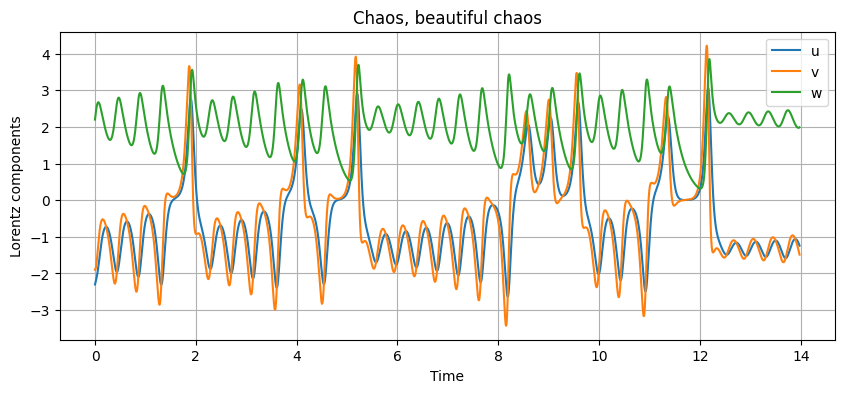

In [6]:
#plot
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(t,u,label="u")
ax.plot(t,v,label="v")
ax.plot(t,w,label="w")
ax.set_xlabel("Time")
ax.set_ylabel("Lorentz components")
ax.set_title("Chaos, beautiful chaos")
ax.legend()
ax.grid();

In [7]:
#generate high-freq chaos (noise)

ic = np.array([-2.3, -1.9, 2.2])  # Initial conditions
tend = 10000 
t = np.linspace(0, tend, len(audio_data))  # Times for simulation
sol = solve_ivp(Lorentz, [0, tend], ic, t_eval=t, atol=1e-9, rtol=1e-8)

u = sol.y[0,:] # extract u(t)




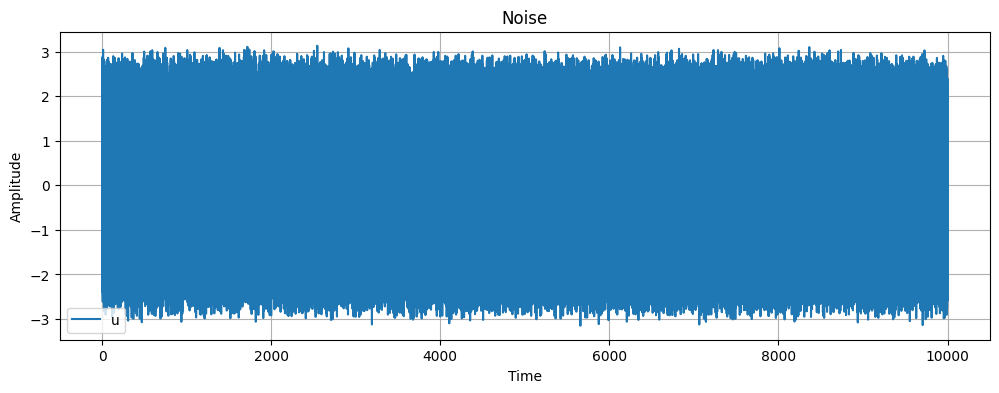

In [8]:
#plot
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(t,u,label="u")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title("Noise")
ax.legend()
ax.grid();

In [9]:
#ensure noise is high-amplitude
u *= 10
wavio.write("noise.wav", u,sample_rate, sampwidth=2)
import IPython
IPython.display.Audio("noise.wav")

/Users/crinkosk/mambaforge/envs/mathproj/lib/python3.12/site-packages/wavio.py:259: ClippedDataWarning: Some data values have been clipped.  With scale=1.0, the interval of input values that will not be clipped is [-1.0000305180437934, 1.0]
  _warnings.warn(ClippedDataWarning(msg))


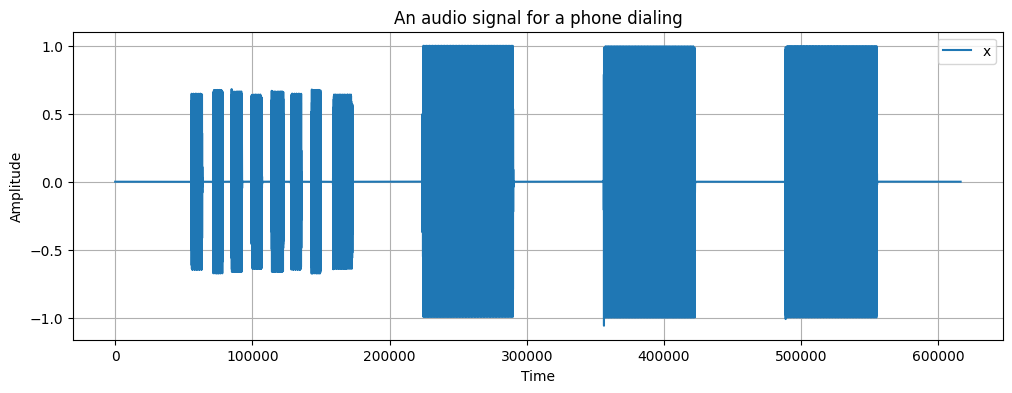

In [10]:
# get secret 'message'

k = wavio.read("phone.wav")
dial = k.data[:,0]/np.abs(k.data.max())
wavio.write("message.wav", dial, 44100, sampwidth=2)

fig,ax = plt.subplots(figsize=(12,4))
ax.plot(np.arange(len(dial)),dial,label="x")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title("An audio signal for a phone dialing")
ax.legend()
ax.grid();

IPython.display.Audio("message.wav")

In [11]:
# Add noise to create masked signal

signal = u + dial
wavio.write("signal.wav",signal,44100,sampwidth=2)
IPython.display.Audio("signal.wav")

Text(0.5, 0.98, 'Secret Message!')

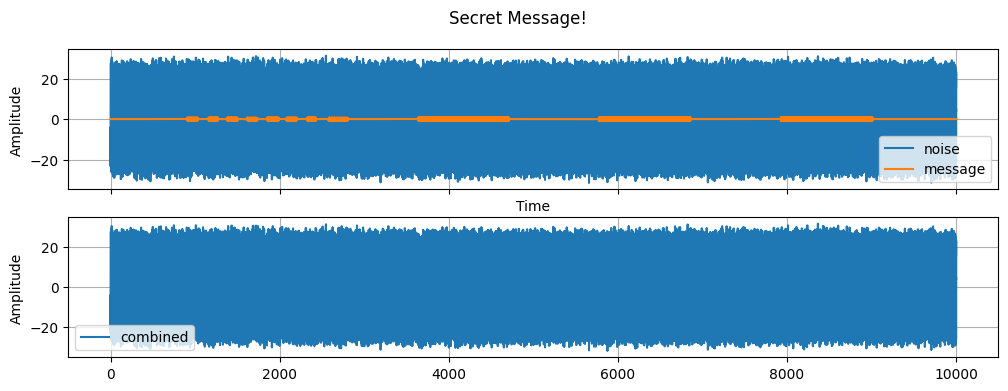

In [29]:
#visualize our progress so far

fig,ax = plt.subplots(nrows=2,figsize=(12,4),sharex=True)
ax[0].plot(t,u,label="noise")
ax[1].plot(t,signal,label="combined")
ax[0].plot(t,dial,label="message")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Amplitude")
fig.suptitle("Secret Message!")


## Recover the message

-2.3
-2.3


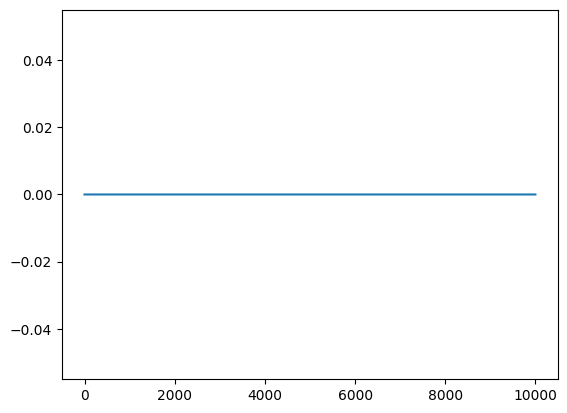

In [69]:
#extract original 'u'
ufun = CubicSpline(t,signal)
interp_sig = ufun(t)
interp_sig /=10

print(interp_sig[0])
print(ufun(0)/10)




plt.plot(t,signal/10-interp_sig)





In [71]:
#reconstruct noise

def Lorentz2(tt,a):
    assert np.isscalar(tt)
    U = a[0]
    V = a[1]
    W = a[2]
    uu = ufun(tt)/10
    dotU = 16*(V-U)
    dotV = uu*(45.6-20*W)-V
    dotW = 5*uu*V - 4*W
    return np.array([dotU,dotV,dotW])

tend = 10000 # simulation end time
sol = solve_ivp(Lorentz2,[0,tend],ic,t_eval=t,atol=1e-9,rtol=1e-8) # :) :) :)
assert sol.success
U = sol.y[0,:] # extract U(t)

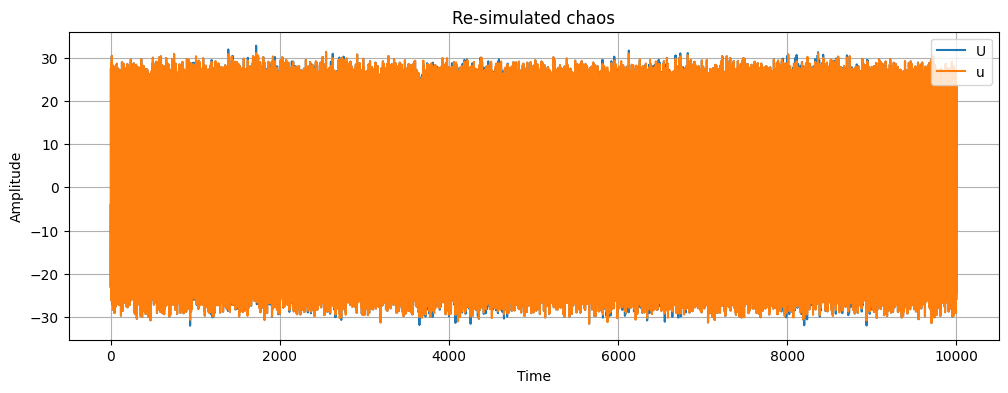

In [72]:
#plot

U *= 10
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(t,U,label="U")
ax.plot(t,u,label="u")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title("Re-simulated chaos")
ax.legend()
ax.grid();

/Users/crinkosk/mambaforge/envs/mathproj/lib/python3.12/site-packages/wavio.py:259: ClippedDataWarning: Some data values have been clipped.  With scale=1.0, the interval of input values that will not be clipped is [-1.0000305180437934, 1.0]
  _warnings.warn(ClippedDataWarning(msg))


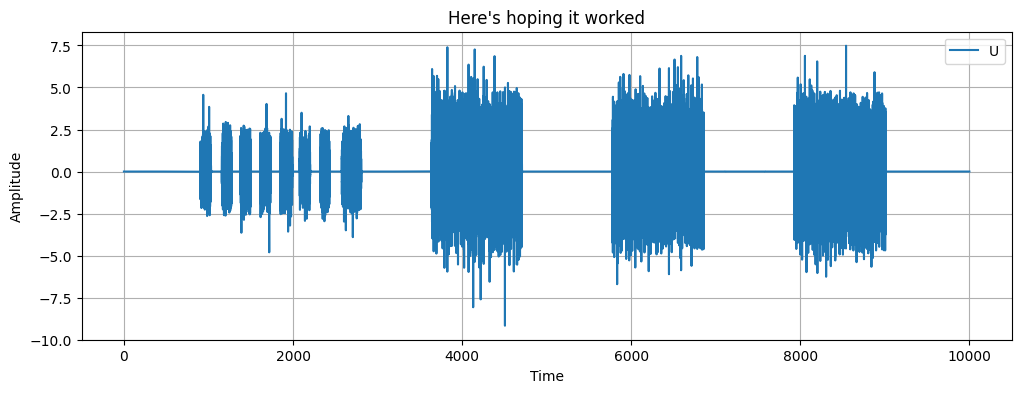

In [73]:
#subtract new noise from signal (recovering the message!)
recoveredmusic = signal - U

fig,ax = plt.subplots(figsize=(12,4))
ax.plot(t,recoveredmusic,label="U")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title("Here's hoping it worked")
ax.legend()
ax.grid();

wavio.write("recoveredmusic.wav",recoveredmusic,44100,sampwidth=2)
IPython.display.Audio("recoveredmusic.wav")